In this notebook, I'll look even deeper into the moving average

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import time

from Particledrop import Landing_Flashes

import trackpy

Let's also try to get an animation in the notebook: IT worked! Not sure why it always also plots the last frame, but it does
This function is now calleable for any movie dataset, so movies or backgroundcorrected movies.


In [121]:
def execute_amovie(moviedata):
    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams['figure.dpi'] = 100  
    plt.ioff()
    
    fig = plt.figure()
    axis = plt.axes()
    
    film = plt.imshow(moviedata[0])
    
    def init(): 
        film.set_data(moviedata[0])
        return [film]
    
    def animate(i):
        film.set_array(moviedata[i])
        return [film]
    
    anim = FuncAnimation(fig, animate, frames = moviedata.shape[0], init_func = init, interval = 200, blit = True)

    return anim



(50, 3)


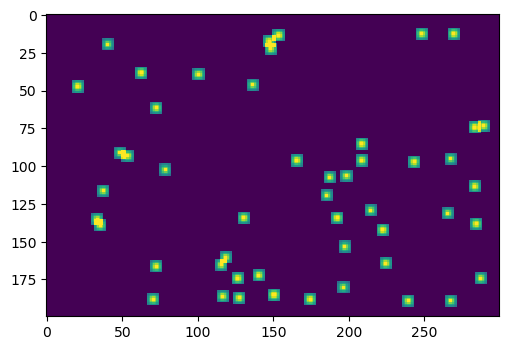

In [94]:
nf = 100
fov=[200,300]
meas = Landing_Flashes(fov=fov, seed=5045, numpar = 50, noise = 0, nframes = nf, signal = 20, sizevar=0.2, dark = 5, psize = 4, unevenIllumination = False)
testframe = nf-1
meas.noise = 0
plis = meas.parlist
movie = meas.genStack()
print(np.shape(plis))

execute_amovie(movie)

With these settings, trackpy finds the particles pretty good, but doesn't find doubles. Let's see if a moving average can change that.




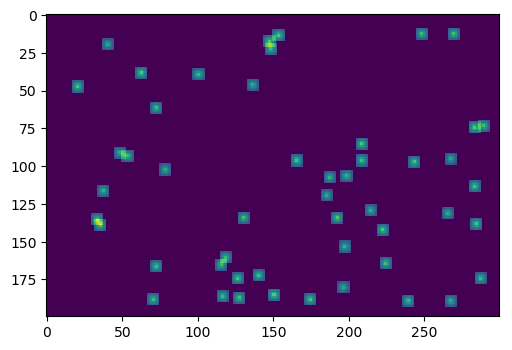

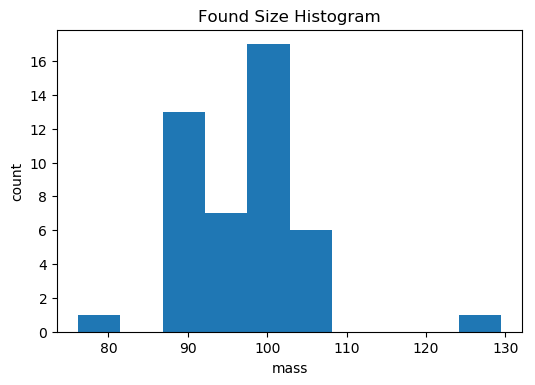

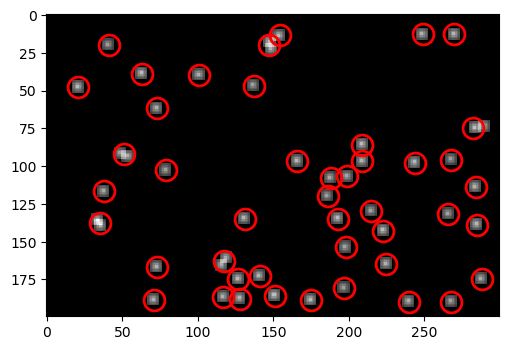

45


In [95]:
plt.figure()
plt.imshow(movie[testframe])

f = trackpy.locate(movie[testframe], 7, minmass = 10, invert = False)

fig, ax = plt.subplots()
plt.title('Found Size Histogram')
ax.hist(f['mass'])

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');
plt.figure()
trackpy.annotate(f, movie[testframe]);

print(len(f['mass']))


How does trackpy batch work? How do you see how many particles it has found?

In [96]:
f_2 = trackpy.batch(movie[:,:,:], 7, minmass=10, invert=False, processes='auto')
print(len(f_2['mass']))

Frame 99: 45 features
2728


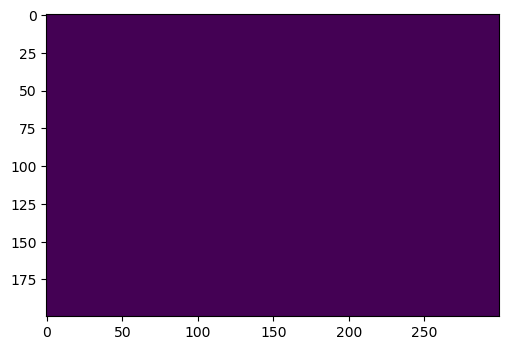

In [97]:
def BGCMovingAverage(movie):
    start = 6
    end = nf

    BGCma = movie[start:end,:,:] - np.mean([movie[start-5:end-5,:,:],
                                          movie[start-4:end-4,:,:],
                                          movie[start-3:end-3,:,:],
                                          movie[start-2:end-2,:,:],
                                          movie[start-1:end-1,:,:]],
                                          axis = 0)
    #Normalization could be important
    BGCma2 = BGCma/movie[0]
    return BGCma2

BGCMA = BGCMovingAverage(movie)
execute_amovie(BGCMA)


Linking should make it so that particles are remembered. It adds a label 'particle' and these are all unique. As you can see, for the movie it still finds less than 50 particles (Still, one lands over the other, trackpy doesn't find it)

In [98]:
f_3 = trackpy.batch(movie[:,:,:], 7, minmass=10, invert=False, processes='auto')
t = trackpy.link(f_3, 5, memory=3)
print(t['particle'].nunique())

Frame 99: 45 trajectories present.
45


Now look at the moving average corrected one:


In [102]:
print(movie.shape)
print(BGCMA.shape)
f_4 = trackpy.batch(BGCMA[:,:,:], 7, minmass=10, invert=False, processes='auto')
#f_4.head

#t2 = trackpy.link(f_4, 5, memory=3)
#print(t2['particle'].nunique())

Frame 86: 0 features


AttributeError: type object 'object' has no attribute 'dtype'

It gives an error at 86, so let's just try less frames

The meas needs to be made new entirely, meas.nframes = 80 cuts it off to early, as it only changes the nframes but keeps the rest the same.

In [114]:
nf = 80
fov=[200,300]
meas = Landing_Flashes(fov=fov, seed=5045, numpar = 50, noise = 0, nframes = nf, signal = 20, sizevar=0.2, dark = 5, psize = 4, unevenIllumination = False)
testframe = nf-1
meas.noise = 0
plis = meas.parlist
movie_short= meas.genStack()
print(np.shape(plis))

(50, 3)


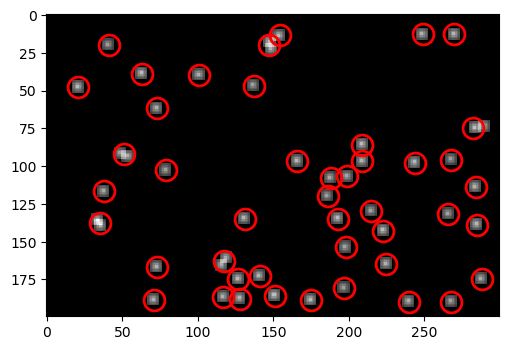

45


In [115]:
f = trackpy.locate(movie_short[testframe], 7, minmass = 10, invert = False)
plt.figure()
trackpy.annotate(f, movie_short[testframe]);

print(len(f['mass']))

In [117]:
BGCMAshort = BGCMovingAverage(movie_short)
f_5 = trackpy.batch(movie[:,:,:], 7, minmass=10, invert=False, processes='auto')
t = trackpy.link(f_5, 5, memory=3)
print(t['particle'].nunique())

Frame 79: 45 trajectories present.
45


In [120]:
f_6 = trackpy.batch(BGCMAshort[:,:,:], 7, minmass=10, invert=False, processes='auto')
t2 = trackpy.link(f_6, 5, memory=3)
print(t2['particle'].nunique())

Frame 72: 1 trajectories present.
48


Still only 48 found? Where does this go wrong...?

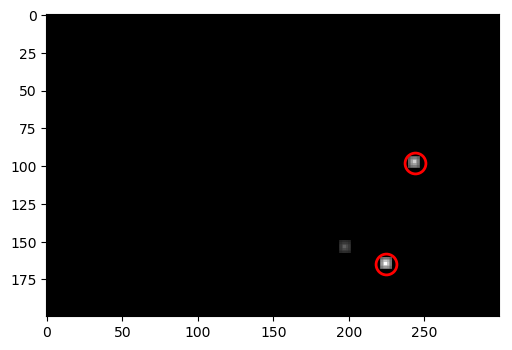

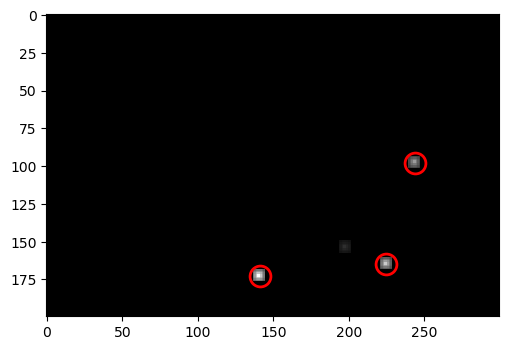

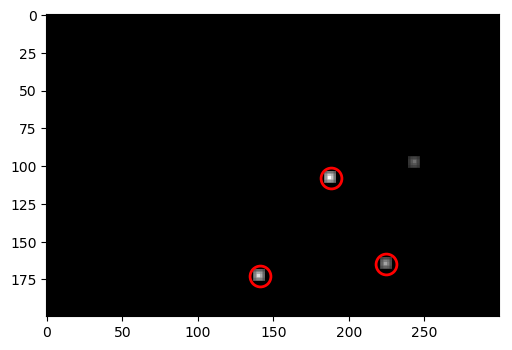

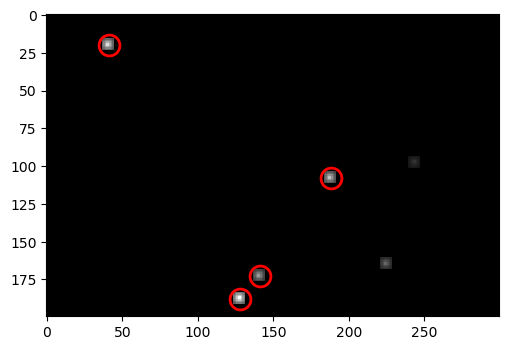

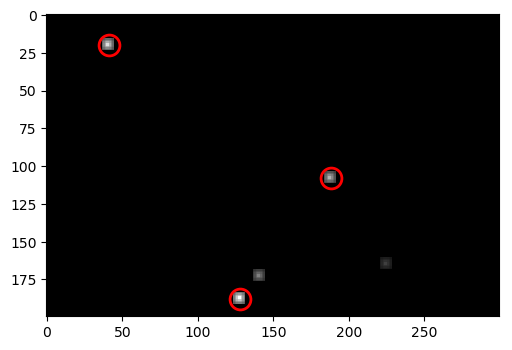

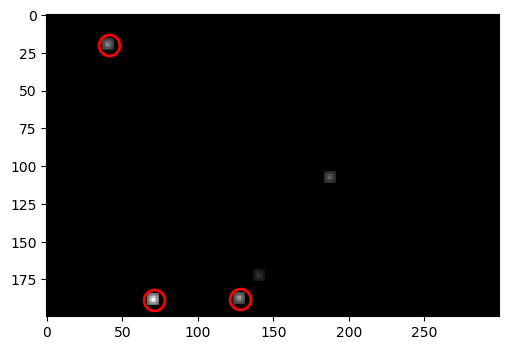

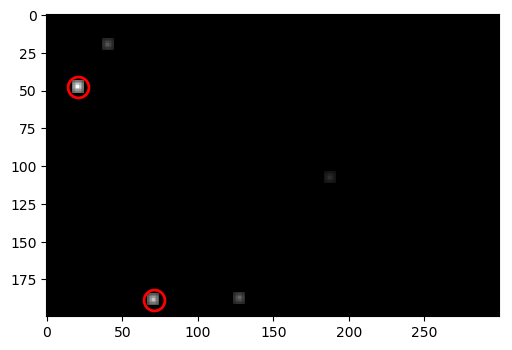

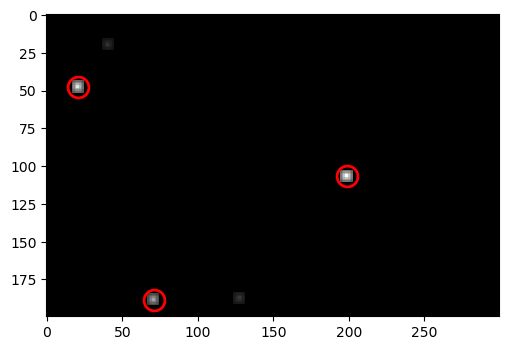

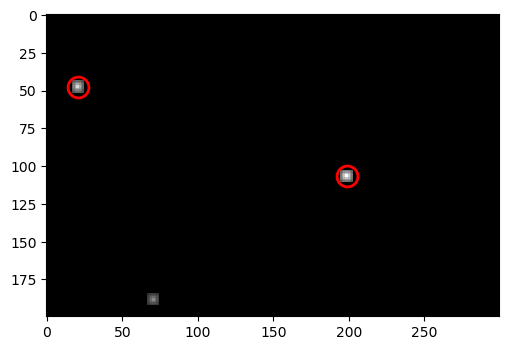

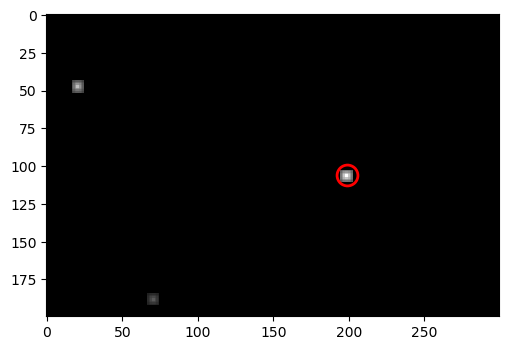

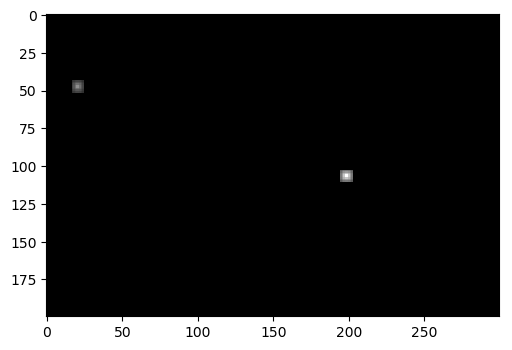

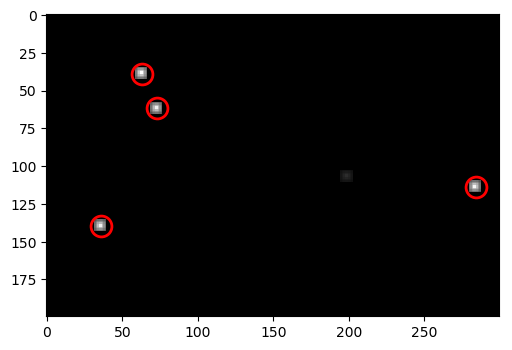

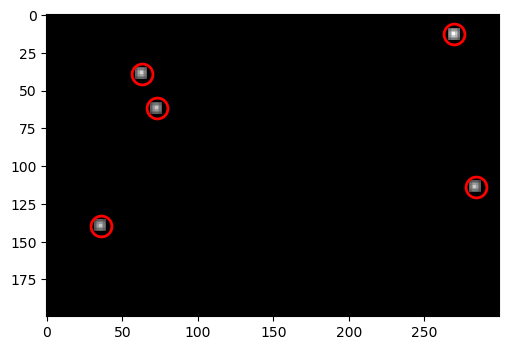

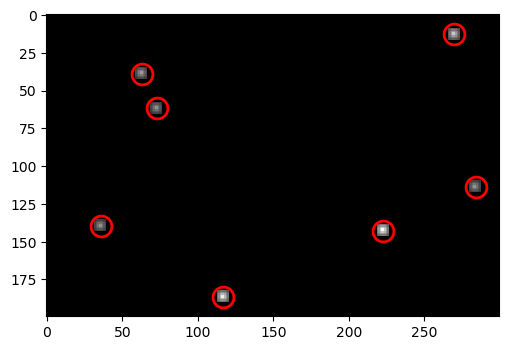

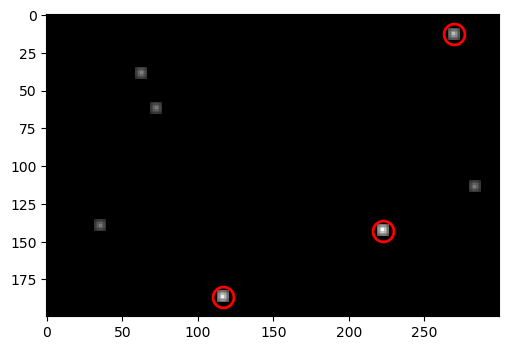

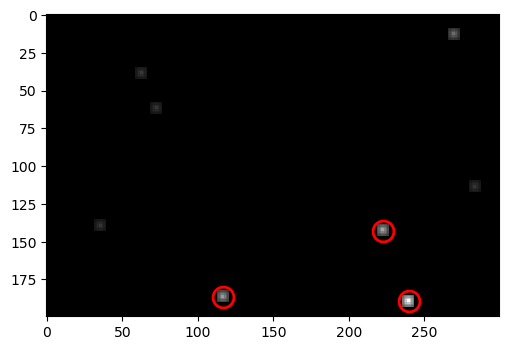

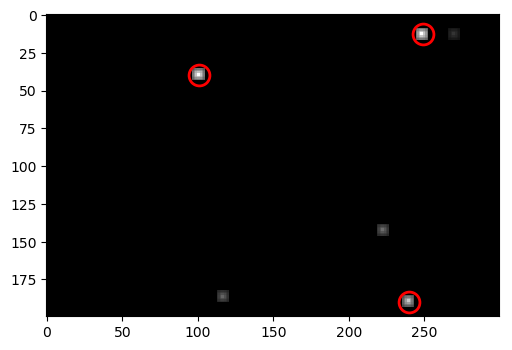

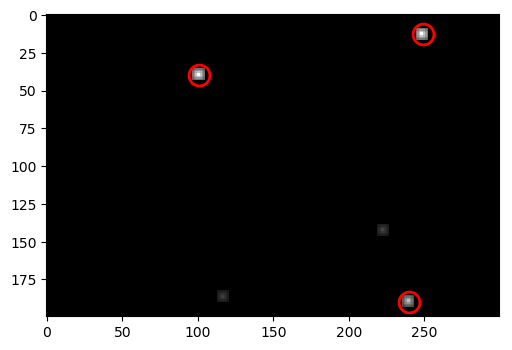

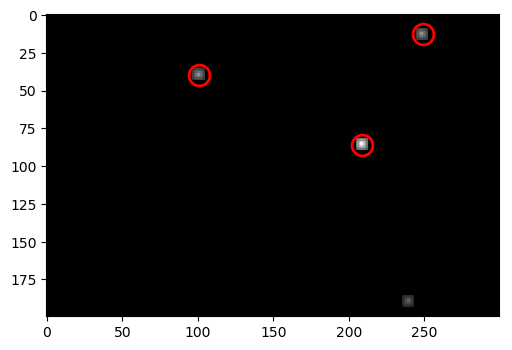

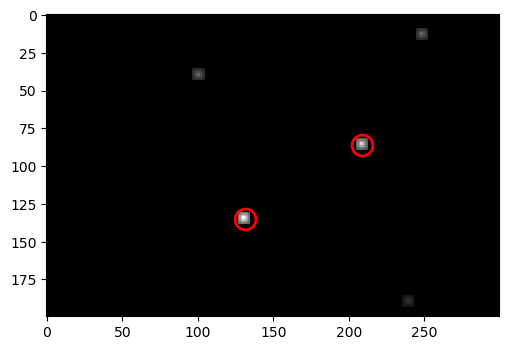

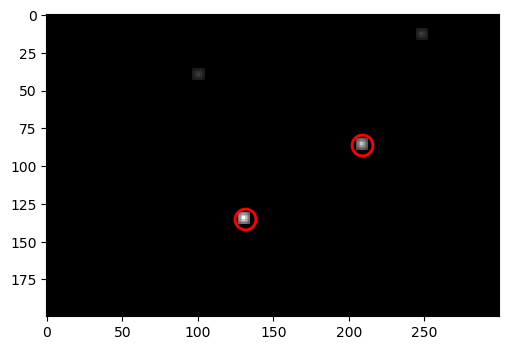

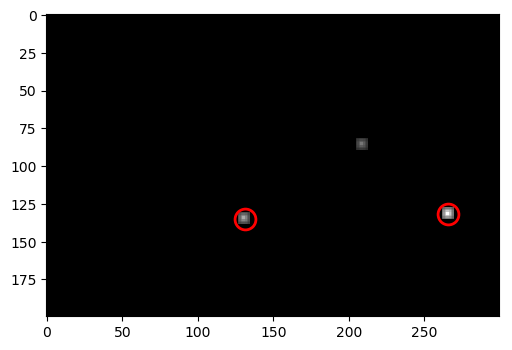

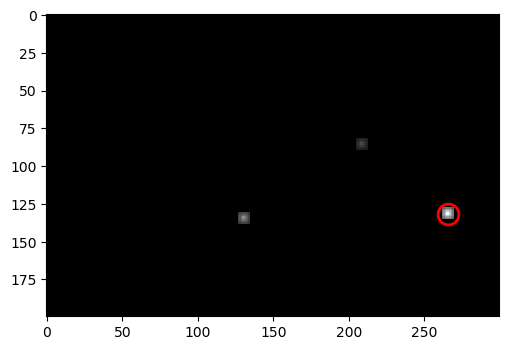

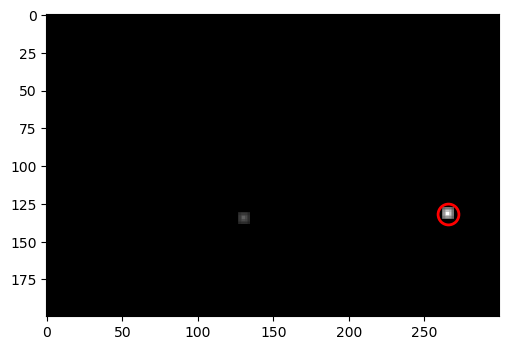

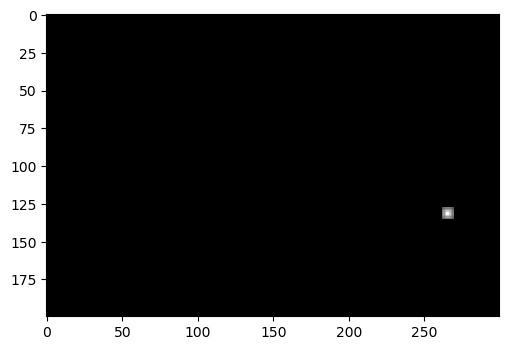

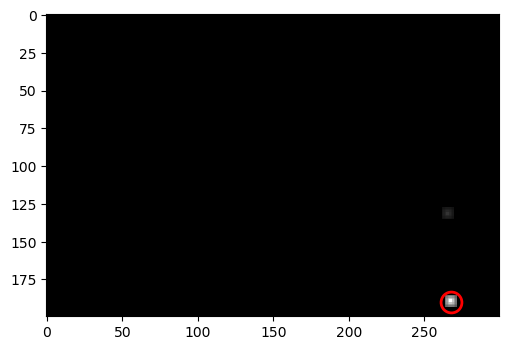

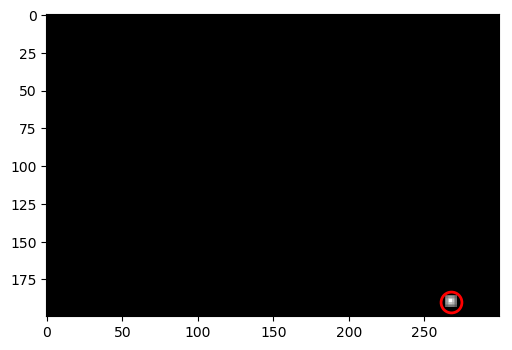

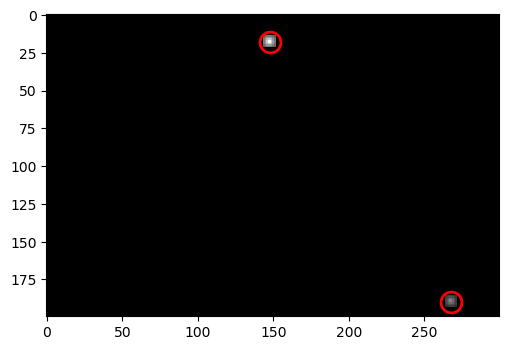

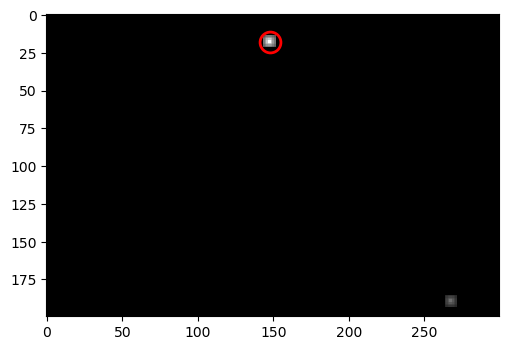

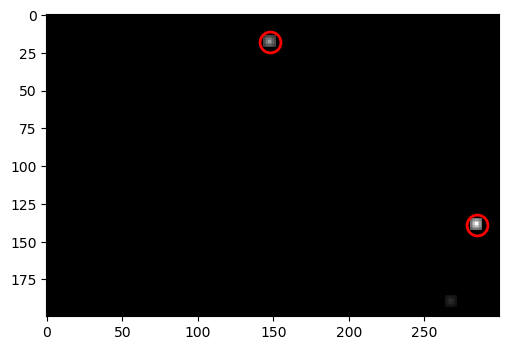

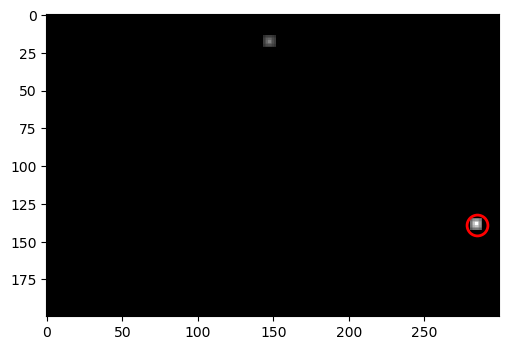

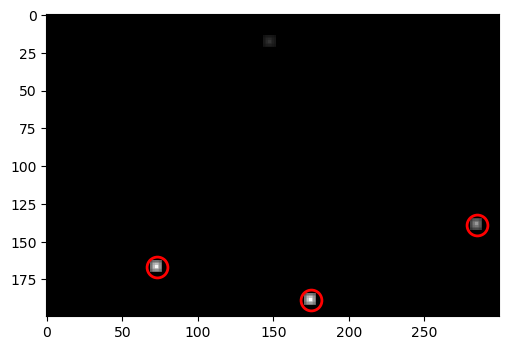

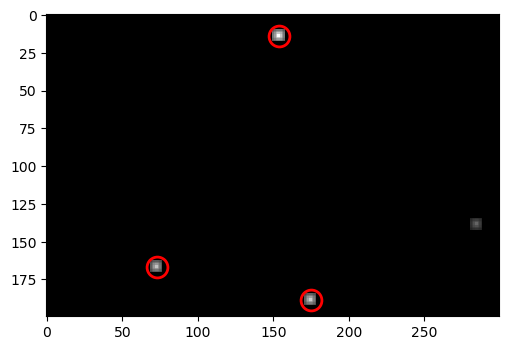

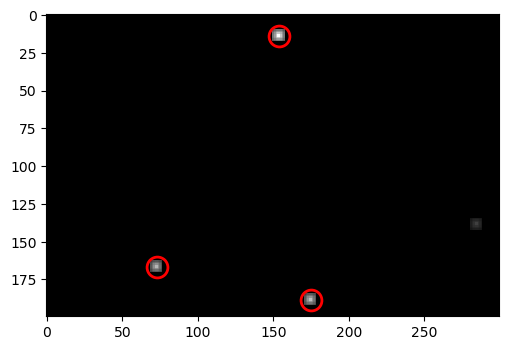

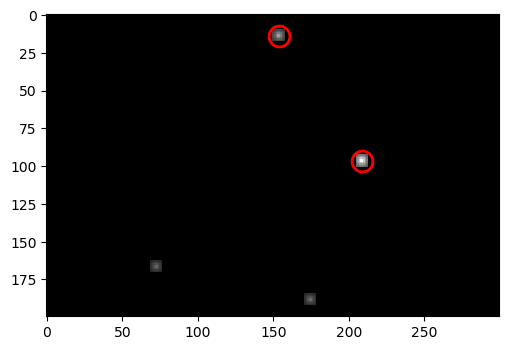

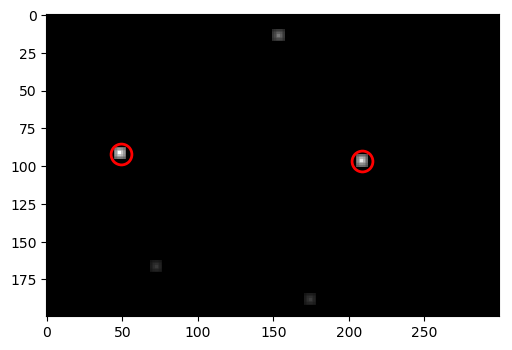

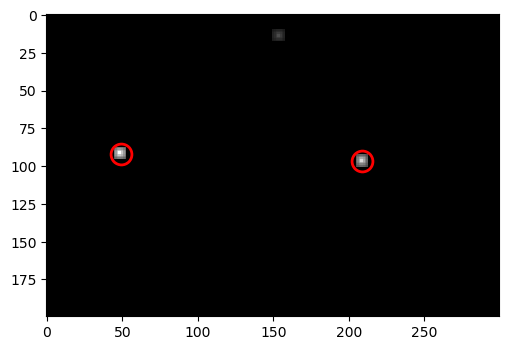

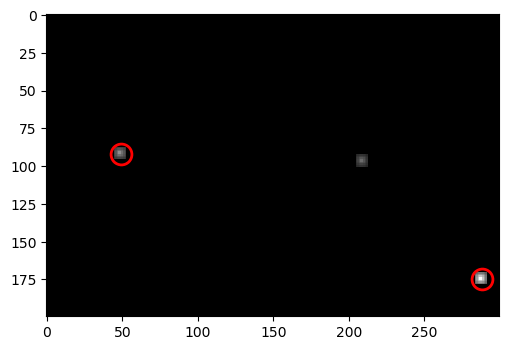

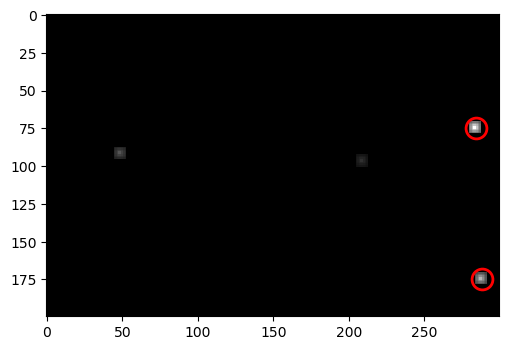

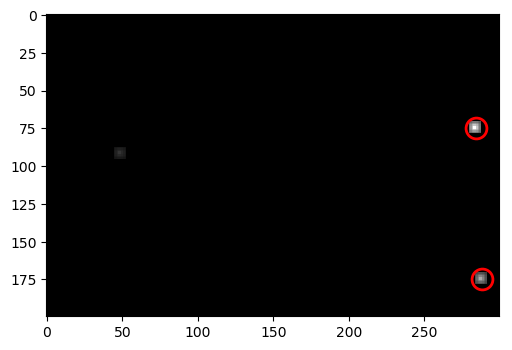

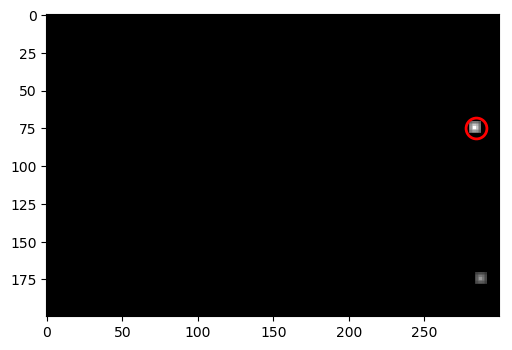

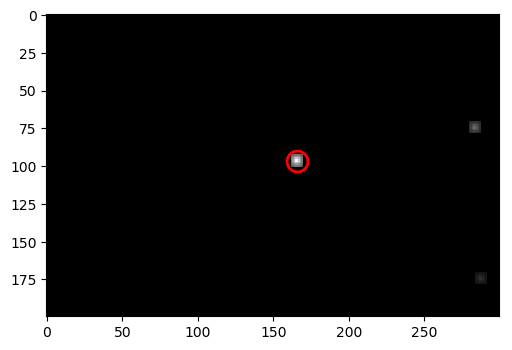

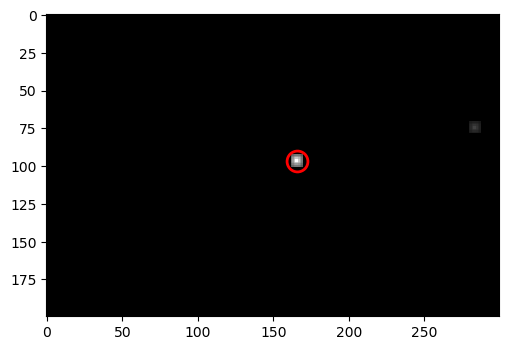

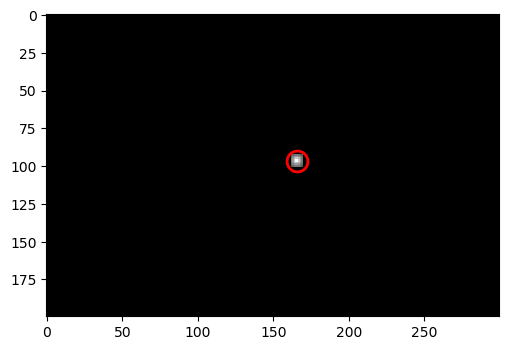

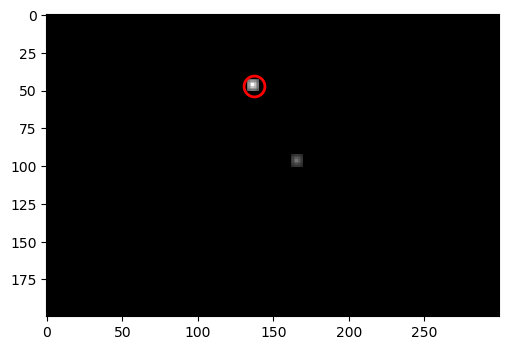

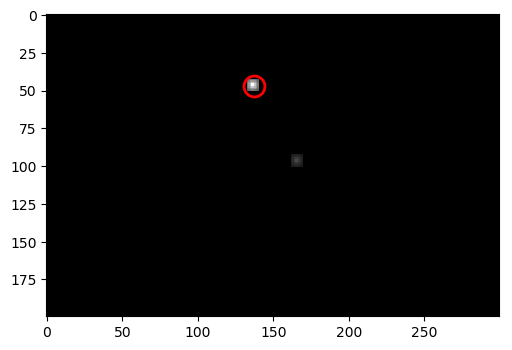

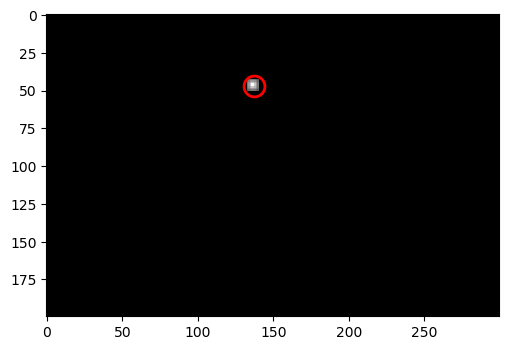

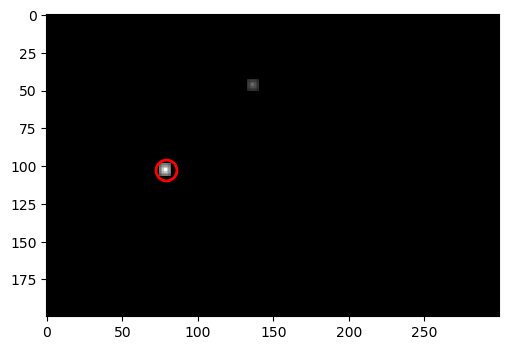

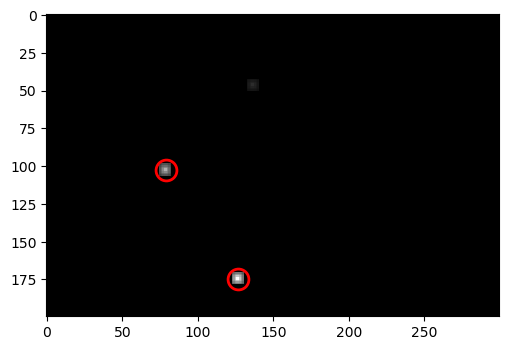

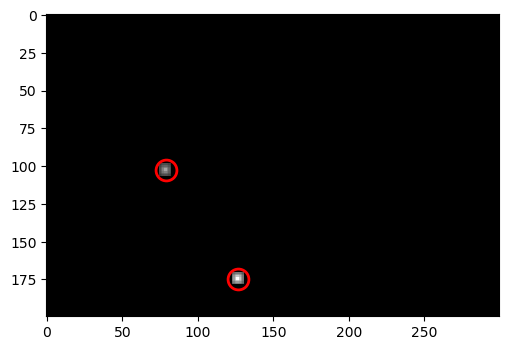

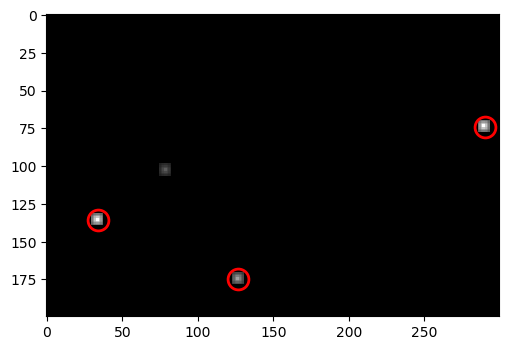

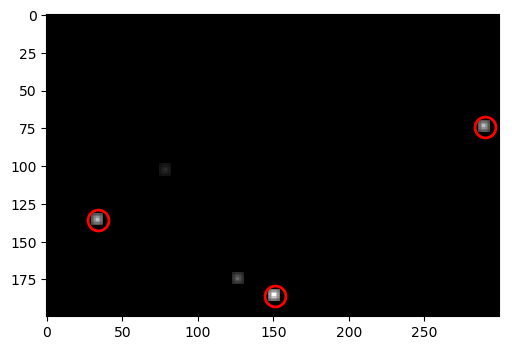

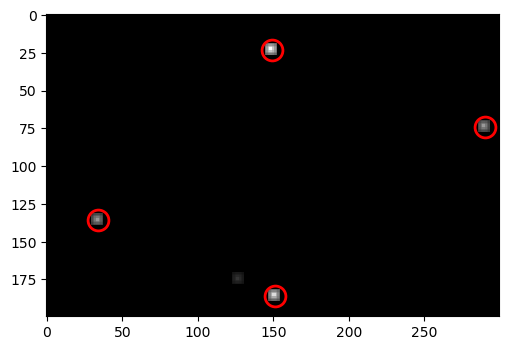

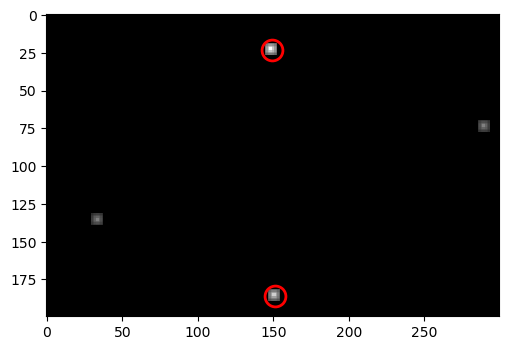

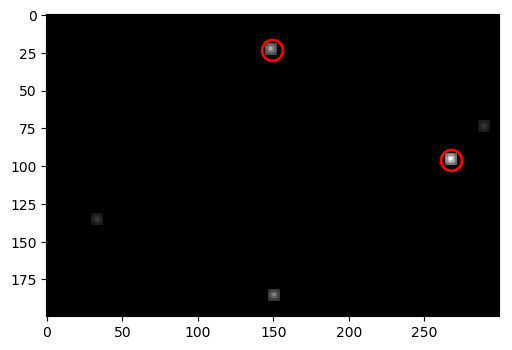

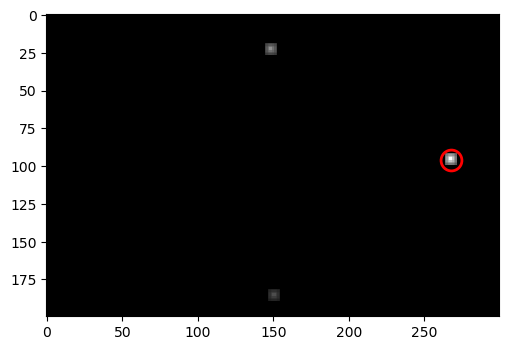

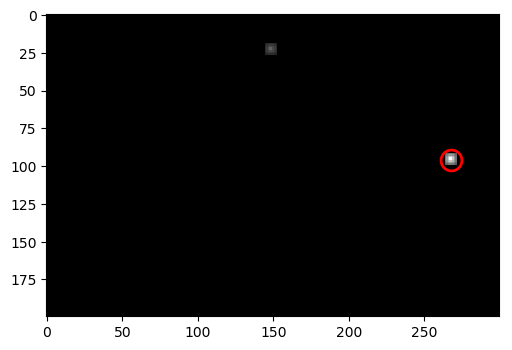

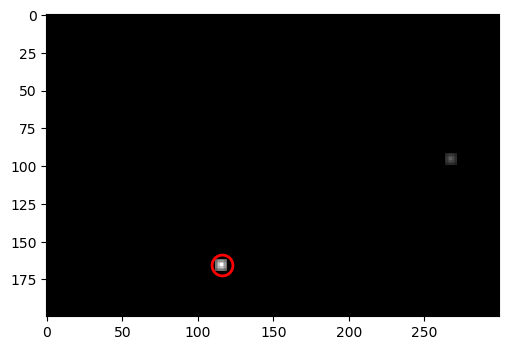

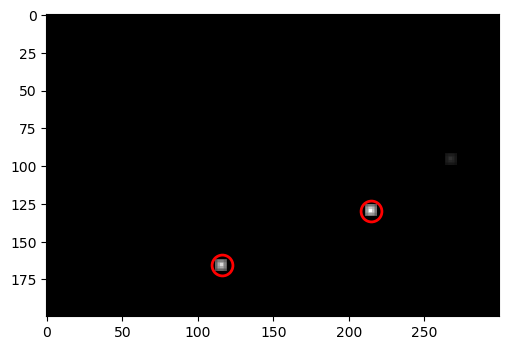

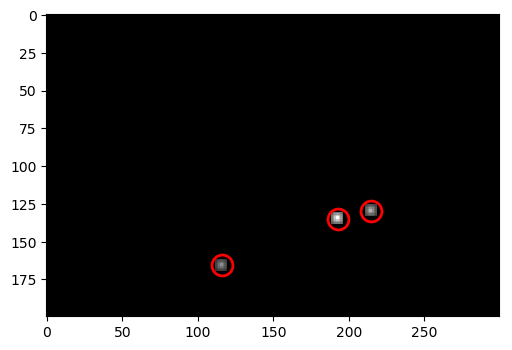

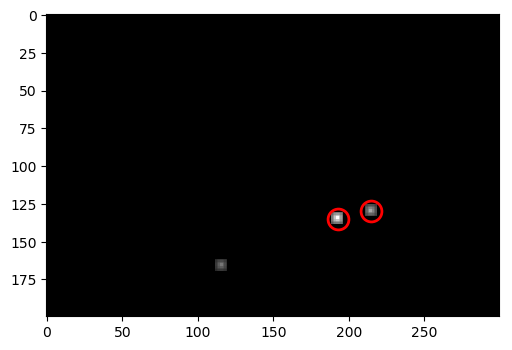

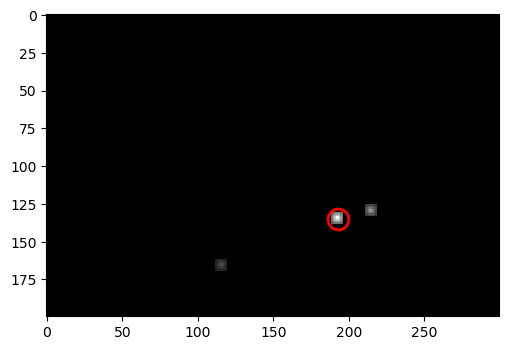

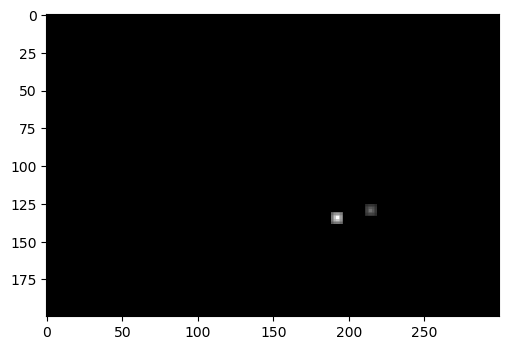

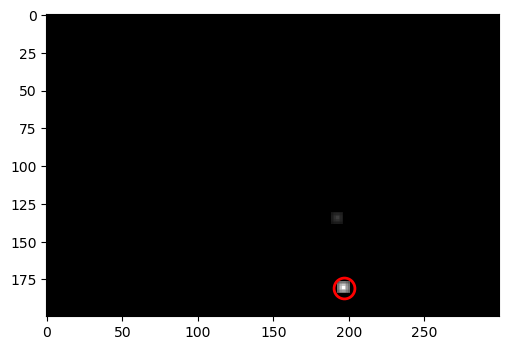

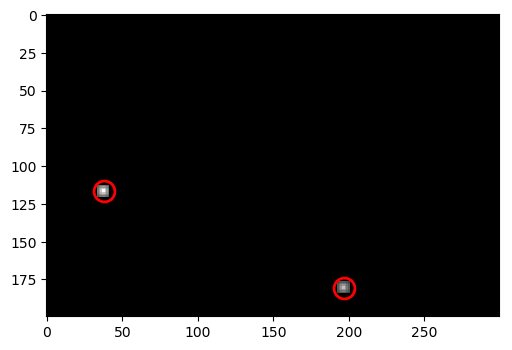

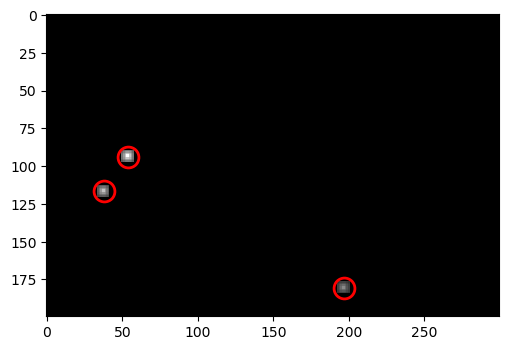

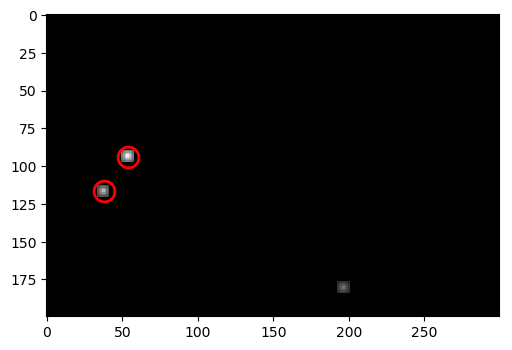

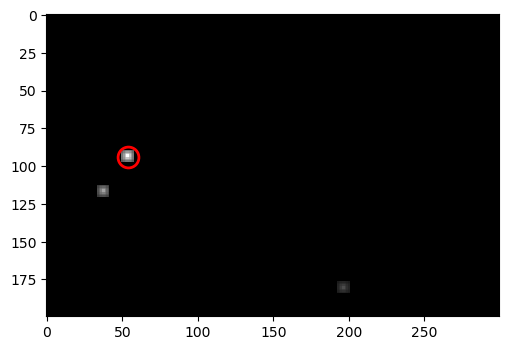

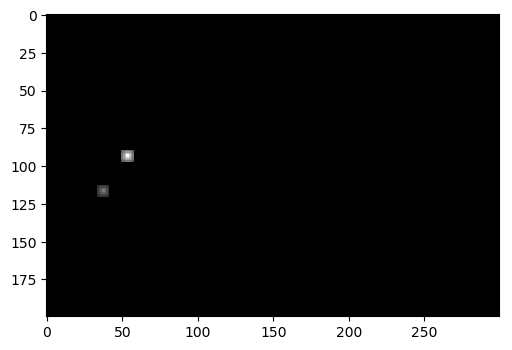

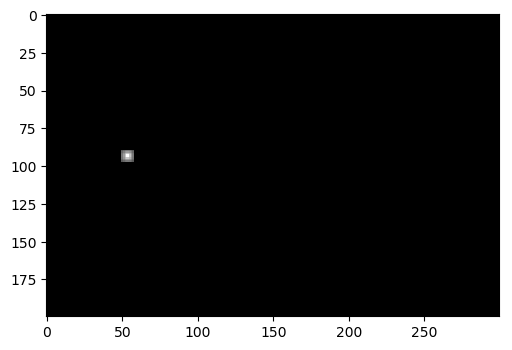

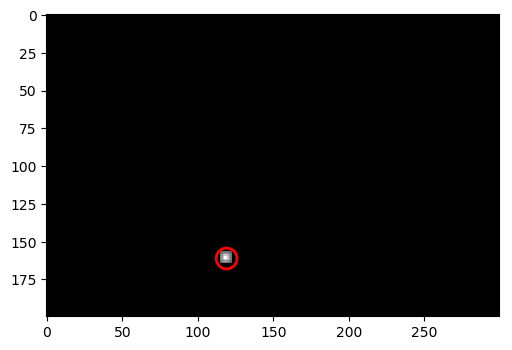

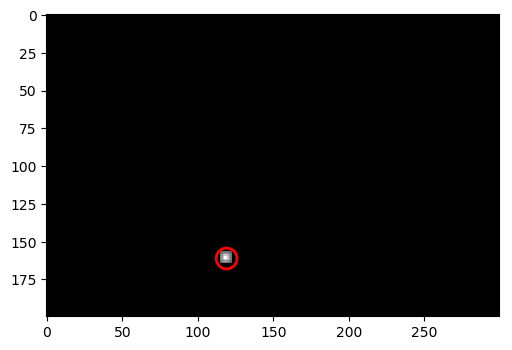

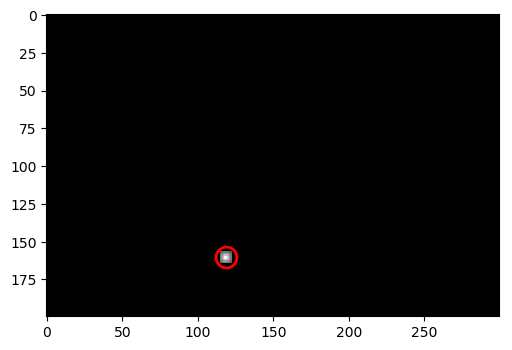

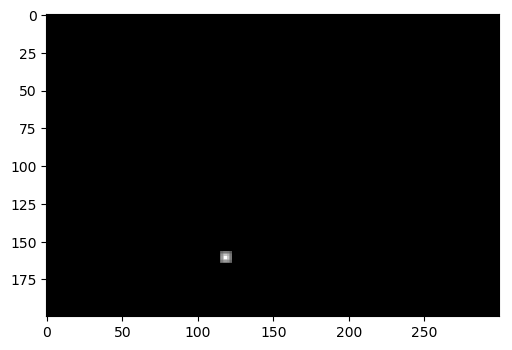

In [127]:
for i in range(nf-6):
    plt.figure()
    trackpy.annotate(t2[t2['frame'] == i], BGCMAshort[i]);

So it does seem it has found everything at least once!! It is visible that one particles was missed at the beginning.
Maybe there are two particles lost at the beginning?

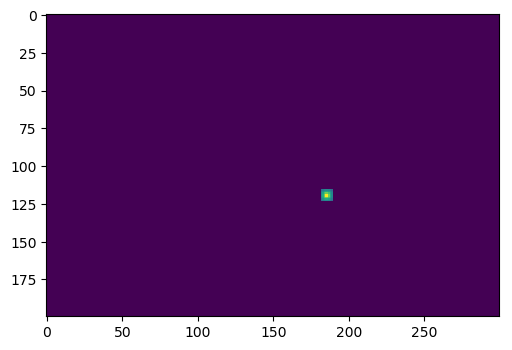

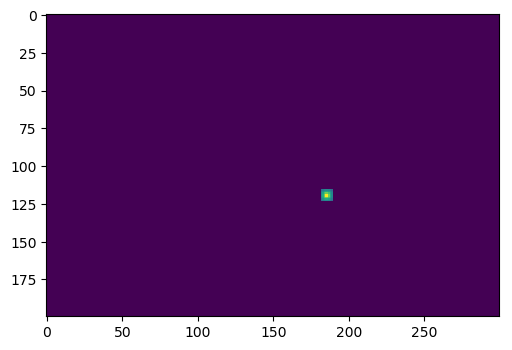

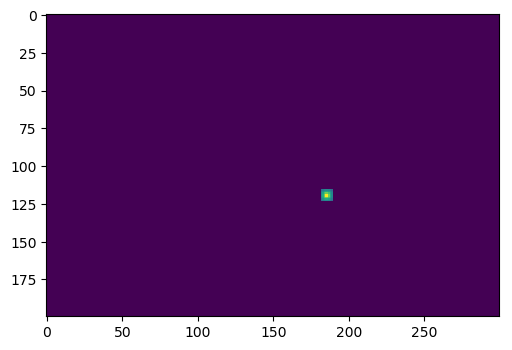

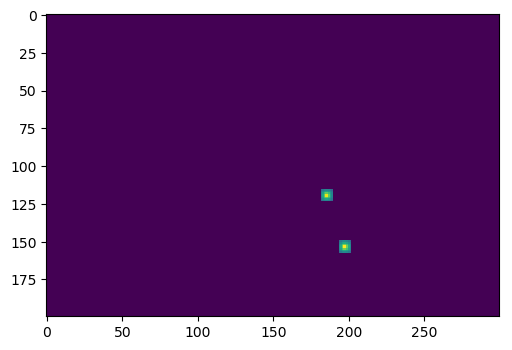

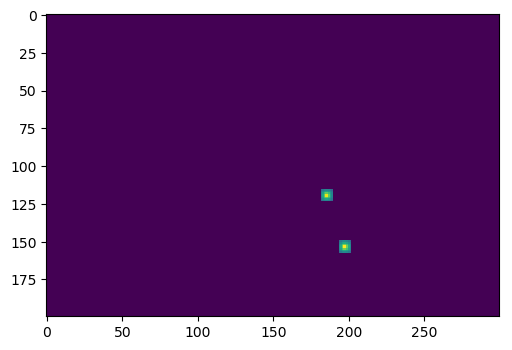

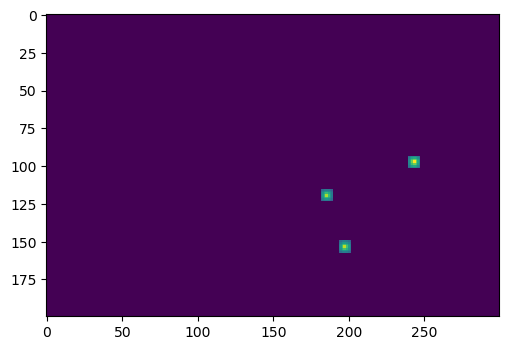

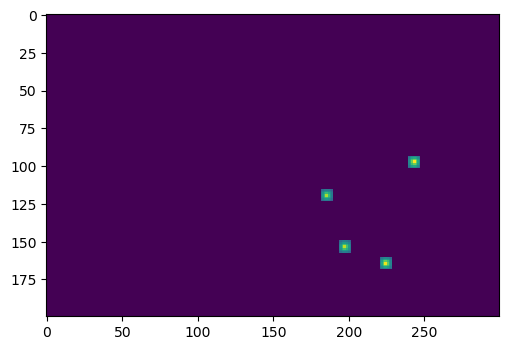

In [135]:
for i in range(7):
    plt.figure()
    plt.imshow(movie_short[i])

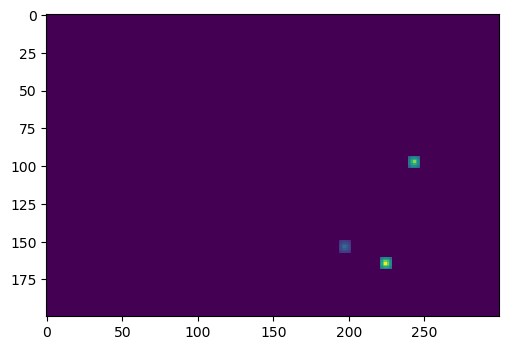

In [130]:
plt.imshow(BGCMA[0])

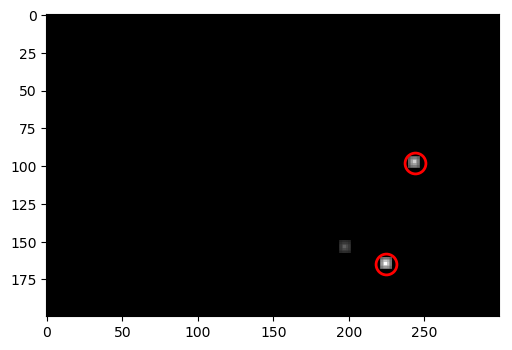

In [134]:
trackpy.annotate(t2[t2['frame'] == 0], BGCMAshort[0]);

Yes! Exactly two particles were missed because of the moving average in the beginning! So with a moving average, all particles in the BGCMA were found!